In [1]:
import pandas as pd 
import numpy as np 

def load_parquet_data(file_path):
    """
    Load cryptocurrency data from a parquet file
    
    Args:
        file_path: Path to the parquet file
        
    Returns:
        pd.DataFrame: DataFrame with cryptocurrency data
    """
    try:
        df = pd.read_parquet(file_path)
        print(f"Successfully loaded data from {file_path}")
        print(f"Shape: {df.shape} (rows, columns)")
        
        if 'symbol' in df.columns:
            # Long format
            print(f"Format: Long format")
            print(f"Date range: {df['open_time'].min()} to {df['open_time'].max()}")
            symbols = df['symbol'].unique()
            print(f"Contains data for {len(symbols)} cryptocurrencies")
        else:
            # Wide format
            print(f"Format: Wide format")
            print(f"Date range: {df.index.min()} to {df.index.max()}")
            symbols = list(set([col.split('_')[0] for col in df.columns if '_' in col]))
            print(f"Contains data for {len(symbols)} cryptocurrencies")
        
        return df
    except Exception as e:
        print(f"Error loading parquet file: {e}")
        return None

def explore_directory_structure(base_path, max_depth=3):
    """
    Explore the directory structure to understand how files are organized
    
    Args:
        base_path: Base path to explore
        max_depth: Maximum depth to explore
    """
    base_path = Path(base_path)
    
    def _explore(path, depth, prefix=""):
        if depth > max_depth:
            return
        
        items = list(path.iterdir())
        items.sort()
        
        for i, item in enumerate(items):
            is_last = i == len(items) - 1
            connector = "└── " if is_last else "├── "
            
            print(f"{prefix}{connector}{item.name}")
            
            if item.is_dir() and depth < max_depth:
                next_prefix = prefix + ("    " if is_last else "│   ")
                _explore(item, depth + 1, next_prefix)
    
    print(f"Directory structure of {base_path}:")
    _explore(base_path, 1)

In [2]:
path = '/Users/mouyasushi/Desktop/quantDevops/Research/Alpha-Research/kline/binance/all_crypto_data_1d_long.parquet'

agg_df = load_parquet_data(path)

Successfully loaded data from /Users/mouyasushi/Desktop/quantDevops/Research/Alpha-Research/kline/binance/all_crypto_data_1d_long.parquet
Shape: (31878, 11) (rows, columns)
Format: Long format
Date range: 2021-01-01 00:00:00 to 2025-02-26 00:00:00
Contains data for 21 cryptocurrencies


In [3]:
agg_df

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,symbol
0,2021-01-01,88.581,91.000,84.652,90.909,368132.6,3.236081e+07,95220,160420.1,1.411901e+07,AAVEUSDT
1,2021-01-02,90.940,92.200,82.573,85.888,350675.1,3.019238e+07,96482,141557.9,1.219980e+07,AAVEUSDT
2,2021-01-03,85.911,95.680,81.338,94.185,490412.4,4.367915e+07,120659,219913.4,1.964500e+07,AAVEUSDT
3,2021-01-04,94.183,115.590,85.932,114.322,1108493.1,1.136470e+08,301713,514642.8,5.291774e+07,AAVEUSDT
4,2021-01-05,114.344,124.279,98.653,119.800,843809.1,9.551636e+07,271640,385402.1,4.365867e+07,AAVEUSDT
...,...,...,...,...,...,...,...,...,...,...,...
31873,2025-02-22,0.870,0.899,0.867,0.893,9587461.5,8.503384e+06,46368,4670777.7,4.143709e+06,XTZUSDT
31874,2025-02-23,0.893,0.895,0.858,0.865,5712478.5,5.005713e+06,39536,2578248.6,2.258186e+06,XTZUSDT
31875,2025-02-24,0.865,0.866,0.761,0.773,19900237.0,1.618839e+07,91384,9703884.8,7.900364e+06,XTZUSDT
31876,2025-02-25,0.772,0.791,0.725,0.777,28215329.7,2.147710e+07,112628,14213387.9,1.081920e+07,XTZUSDT


Check Data quality 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_crypto_data(agg_data):
    """
    Perform EDA operations on the already loaded cryptocurrency dataframe
    
    Args:
        agg_data (pd.DataFrame): DataFrame with cryptocurrency data
        
    Returns:
        pd.DataFrame: DataFrame with tickers in first column and analysis results
    """
    # 1. Move ticker (symbol) to the first column
    if 'symbol' in agg_data.columns:
        # Reorder columns to put symbol first
        cols = ['symbol'] + [col for col in agg_data.columns if col != 'symbol']
        agg_data = agg_data[cols]
    
    # If the DataFrame doesn't have a 'date' column but has 'open_time', parse it
    if 'date' not in agg_data.columns and 'open_time' in agg_data.columns:
        # Check if open_time contains date information 
        if isinstance(agg_data['open_time'].iloc[0], str) and len(agg_data['open_time'].iloc[0]) > 8:
            # Try to extract date from open_time if it's in a format like '02021-01-01'
            agg_data['date'] = agg_data['open_time'].str.extract(r'(\d{4}-\d{2}-\d{2})').iloc[:, 0]
            agg_data['open_time'] = agg_data['open_time'].str.extract(r'^(\d+)').iloc[:, 0]
            
        # Convert date to datetime if it exists
        if 'date' in agg_data.columns:
            agg_data['date'] = pd.to_datetime(agg_data['date'])
    
    # 2. Find the length (dates) that all coins have
    # Get unique symbols
    symbols = agg_data['symbol'].unique()
    print(f"Found {len(symbols)} unique symbols: {', '.join(symbols)}")
    
    # Date range analysis
    date_ranges = {}
    for symbol in symbols:
        symbol_data = agg_data[agg_data['symbol'] == symbol]
        if 'date' in agg_data.columns:
            min_date = symbol_data['date'].min()
            max_date = symbol_data['date'].max()
            date_count = symbol_data['date'].nunique()
            
            date_ranges[symbol] = {
                'start': min_date,
                'end': max_date,
                'count': date_count,
                'trading_days': len(symbol_data)
            }
        else:
            # If no date column, use index ranges
            min_idx = symbol_data['open_time'].astype(int).min()
            max_idx = symbol_data['open_time'].astype(int).max()
            idx_count = symbol_data['open_time'].nunique()
            
            date_ranges[symbol] = {
                'start_idx': min_idx,
                'end_idx': max_idx,
                'count': idx_count,
                'trading_days': len(symbol_data)
            }
    
    # Find common date coverage
    if 'date' in agg_data.columns:
        all_dates = agg_data.groupby('date')['symbol'].apply(set).to_dict()
        dates_with_all_symbols = [date for date, syms in all_dates.items() if len(syms) == len(symbols)]
        
        print(f"\nDates with data for all symbols: {len(dates_with_all_symbols)}")
        if len(dates_with_all_symbols) > 0:
            print(f"Common date range: {min(dates_with_all_symbols)} to {max(dates_with_all_symbols)}")
    
    # 3. Check for NaNs and perform stats by coin
    numeric_cols = agg_data.select_dtypes(include=[np.number]).columns.tolist()
    
    stats_by_symbol = {}
    for symbol in symbols:
        symbol_data = agg_data[agg_data['symbol'] == symbol]
        
        # NaN counts
        nan_counts = {col: symbol_data[col].isna().sum() for col in numeric_cols}
        nan_percentage = {col: (symbol_data[col].isna().sum() / len(symbol_data)) * 100 
                         for col in numeric_cols if symbol_data[col].isna().sum() > 0}
        
        # Basic statistics
        stats = symbol_data[numeric_cols].describe()
        
        stats_by_symbol[symbol] = {
            'count': len(symbol_data),
            'nan_counts': nan_counts,
            'nan_percentage': nan_percentage,
            'stats': stats
        }
    
    # Display results
    print("\nDate ranges by symbol:")
    for symbol, info in date_ranges.items():
        if 'start' in info:
            print(f"{symbol}: {info['start']} to {info['end']} ({info['count']} unique dates)")
        else:
            print(f"{symbol}: Index {info['start_idx']} to {info['end_idx']} ({info['count']} unique indices)")
    
    print("\nNaN analysis by symbol:")
    for symbol, stats in stats_by_symbol.items():
        print(f"\n{symbol}:")
        if any(stats['nan_counts'].values()):
            print("  Columns with NaN values:")
            for col, count in stats['nan_counts'].items():
                if count > 0:
                    percentage = stats['nan_percentage'][col]
                    print(f"    {col}: {count} NaNs ({percentage:.2f}%)")
        else:
            print("  No NaN values found")
    
    print("\nBasic statistics by symbol:")
    for symbol, stats_info in stats_by_symbol.items():
        print(f"\n{symbol} statistics (sample):")
        # Print a subset of stats for brevity
        if 'close' in numeric_cols:
            close_stats = stats_info['stats']['close']
            print(f"  Close price - Min: {close_stats['min']:.4f}, Max: {close_stats['max']:.4f}, Mean: {close_stats['mean']:.4f}")
        if 'volume' in numeric_cols:
            volume_stats = stats_info['stats']['volume']
            print(f"  Volume - Min: {volume_stats['min']:.2f}, Max: {volume_stats['max']:.2f}, Mean: {volume_stats['mean']:.2f}")
    
    return agg_data

# This function will be used directly with the already loaded agg_data
# Example usage: 
#   analyzed_df = analyze_crypto_data(agg_data)

In [5]:
df = analyze_crypto_data(agg_df)
df

Found 21 unique symbols: AAVEUSDT, ADAUSDT, AVAXUSDT, BCHUSDT, BNBUSDT, BTCUSDT, DOGEUSDT, DOTUSDT, ETCUSDT, ETHUSDT, LINKUSDT, LTCUSDT, NEARUSDT, SOLUSDT, THETAUSDT, TRXUSDT, UNIUSDT, VETUSDT, XLMUSDT, XRPUSDT, XTZUSDT

Date ranges by symbol:
AAVEUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
ADAUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
AVAXUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
BCHUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
BNBUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
BTCUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
DOGEUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
DOTUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
ETCUSDT: Index 1609459200000000000 to 1740528000000000000 (1518 unique indices)
ETHUSDT: Index 160945920000000000

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,AAVEUSDT,2021-01-01,88.581,91.000,84.652,90.909,368132.6,3.236081e+07,95220,160420.1,1.411901e+07
1,AAVEUSDT,2021-01-02,90.940,92.200,82.573,85.888,350675.1,3.019238e+07,96482,141557.9,1.219980e+07
2,AAVEUSDT,2021-01-03,85.911,95.680,81.338,94.185,490412.4,4.367915e+07,120659,219913.4,1.964500e+07
3,AAVEUSDT,2021-01-04,94.183,115.590,85.932,114.322,1108493.1,1.136470e+08,301713,514642.8,5.291774e+07
4,AAVEUSDT,2021-01-05,114.344,124.279,98.653,119.800,843809.1,9.551636e+07,271640,385402.1,4.365867e+07
...,...,...,...,...,...,...,...,...,...,...,...
31873,XTZUSDT,2025-02-22,0.870,0.899,0.867,0.893,9587461.5,8.503384e+06,46368,4670777.7,4.143709e+06
31874,XTZUSDT,2025-02-23,0.893,0.895,0.858,0.865,5712478.5,5.005713e+06,39536,2578248.6,2.258186e+06
31875,XTZUSDT,2025-02-24,0.865,0.866,0.761,0.773,19900237.0,1.618839e+07,91384,9703884.8,7.900364e+06
31876,XTZUSDT,2025-02-25,0.772,0.791,0.725,0.777,28215329.7,2.147710e+07,112628,14213387.9,1.081920e+07


In [6]:
df[df['open_time'] == '2021-01-01'].head()

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,AAVEUSDT,2021-01-01,88.58100,91.0000,84.65200,90.90900,3.681326e+05,3.236081e+07,95220,1.604201e+05,1.411901e+07
1518,ADAUSDT,2021-01-01,0.18158,0.1851,0.16999,0.17517,6.543882e+08,1.172439e+08,316213,2.855841e+08,5.126660e+07
3036,AVAXUSDT,2021-01-01,3.18940,3.8455,3.04790,3.65410,1.528598e+07,5.356020e+07,220624,7.371867e+06,2.589576e+07
4554,BCHUSDT,2021-01-01,342.49000,355.9600,331.00000,342.00000,5.030654e+05,1.740276e+08,380994,2.337992e+05,8.092611e+07
6072,BNBUSDT,2021-01-01,37.40000,39.0820,37.00000,37.79500,2.613623e+06,9.934429e+07,264595,1.190776e+06,4.526033e+07


Calcualte Daily Return, Log(return), Volatility 
- need to set window for vol: 
    - 7 
    - 14
    - 30 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 確保 open_time 欄位是日期時間格式
df['open_time'] = pd.to_datetime(df['open_time'])

# 按照 symbol 和時間排序
df = df.sort_values(['symbol', 'open_time'])

# 計算每日收益率 (Daily Return)
df['daily_return'] = df.groupby('symbol')['close'].pct_change()

# 計算對數收益率 (Log Return) - 正確地按 symbol 分組
df['log_return'] = df.groupby('symbol').apply(
    lambda x: np.log(x['close'] / x['close'].shift(1))
).reset_index(level=0, drop=True)

# 創建一個空的 DataFrame 來存儲最終結果
result_df = df.copy()
result_df['volatility_7d'] = np.nan
result_df['volatility_14d'] = np.nan
result_df['volatility_30d'] = np.nan

# 對每個 symbol 單獨計算波動率
for symbol, group in df.groupby('symbol'):
    # 計算滾動波動率
    vol_7d = group['log_return'].rolling(window=7).std()
    vol_14d = group['log_return'].rolling(window=14).std()
    vol_30d = group['log_return'].rolling(window=30).std()
    
    # 使用索引來更新原始 DataFrame
    result_df.loc[group.index, 'volatility_7d'] = vol_7d
    result_df.loc[group.index, 'volatility_14d'] = vol_14d
    result_df.loc[group.index, 'volatility_30d'] = vol_30d

# 將計算結果賦值回 df
df = result_df

# 顯示結果
print("前 10 行資料:")
print(df[['symbol', 'open_time', 'close', 'daily_return', 'log_return', 'volatility_30d']].head(10))

# 確認每個 symbol 的第一行是否正確設置為 NaN
first_rows_check = df.groupby('symbol').head(1)[['symbol', 'daily_return', 'log_return']]
print("\n每個 symbol 的第一行檢查:")
print(first_rows_check)

# 基本統計數據
summary_stats = df.groupby('symbol')[['daily_return', 'log_return', 'volatility_30d']].describe()
print("\n每個加密貨幣的基本統計數據：")
print(summary_stats)

# 繪製某個代幣的每日收益率和波動率


前 10 行資料:
     symbol  open_time    close  daily_return  log_return  volatility_30d
0  AAVEUSDT 2021-01-01   90.909           NaN         NaN             NaN
1  AAVEUSDT 2021-01-02   85.888     -0.055231   -0.056815             NaN
2  AAVEUSDT 2021-01-03   94.185      0.096603    0.092217             NaN
3  AAVEUSDT 2021-01-04  114.322      0.213803    0.193758             NaN
4  AAVEUSDT 2021-01-05  119.800      0.047917    0.046805             NaN
5  AAVEUSDT 2021-01-06  115.719     -0.034065   -0.034659             NaN
6  AAVEUSDT 2021-01-07  115.235     -0.004183   -0.004191             NaN
7  AAVEUSDT 2021-01-08  110.686     -0.039476   -0.040276             NaN
8  AAVEUSDT 2021-01-09  117.674      0.063134    0.061221             NaN
9  AAVEUSDT 2021-01-10  126.987      0.079142    0.076167             NaN

每個 symbol 的第一行檢查:
          symbol  daily_return  log_return
0       AAVEUSDT           NaN         NaN
1518     ADAUSDT           NaN         NaN
3036    AVAXUSDT           N

/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_7697/1206423084.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['log_return'] = df.groupby('symbol').apply(


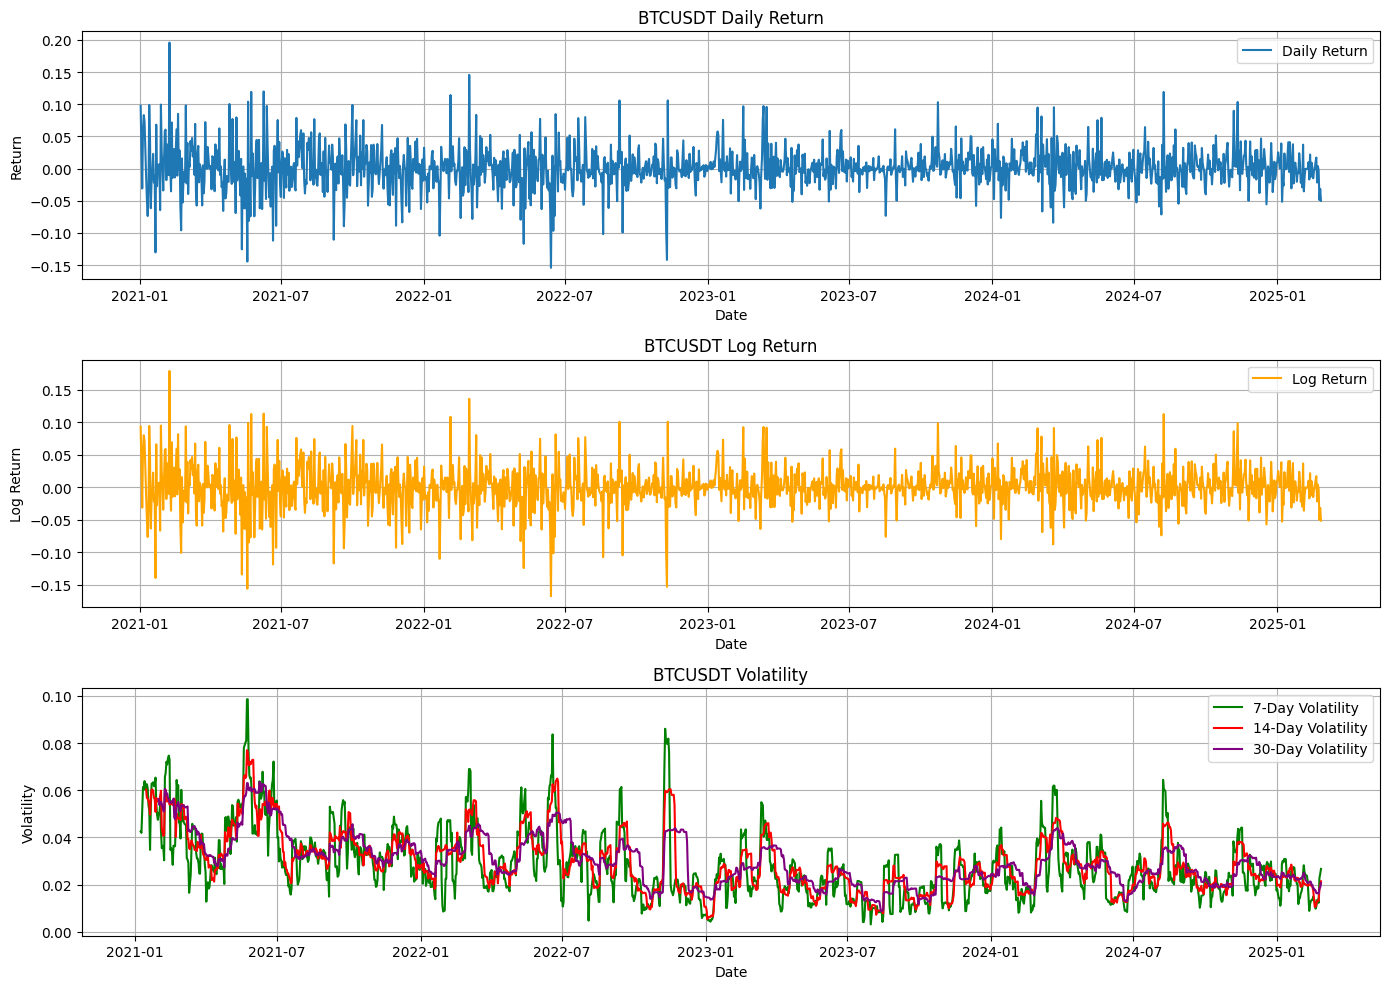

In [9]:
def plot_returns_volatility(symbol_name):
    symbol_data = df[df['symbol'] == symbol_name].copy()
    
    plt.figure(figsize=(14, 10))
    
    # 每日收益率
    plt.subplot(3, 1, 1)
    plt.plot(symbol_data['open_time'], symbol_data['daily_return'], label='Daily Return')
    plt.title(f'{symbol_name} Daily Return')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.grid(True)
    plt.legend()
    
    # 對數收益率
    plt.subplot(3, 1, 2)
    plt.plot(symbol_data['open_time'], symbol_data['log_return'], label='Log Return', color='orange')
    plt.title(f'{symbol_name} Log Return')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.grid(True)
    plt.legend()
    
    # 波動率
    plt.subplot(3, 1, 3)
    plt.plot(symbol_data['open_time'], symbol_data['volatility_7d'], label='7-Day Volatility', color='green')
    plt.plot(symbol_data['open_time'], symbol_data['volatility_14d'], label='14-Day Volatility', color='red')
    plt.plot(symbol_data['open_time'], symbol_data['volatility_30d'], label='30-Day Volatility', color='purple')
    plt.title(f'{symbol_name} Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# edit here to plot 
plot_returns_volatility('BTCUSDT')



In [10]:
df[df['symbol']== 'BTCUSDT'].head(10)

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,daily_return,log_return,volatility_7d,volatility_14d,volatility_30d
7590,BTCUSDT,2021-01-01,28948.19,29668.86,28627.12,29337.16,210716.398,6.157505e+09,1511793,101247.902,2.960176e+09,NaN,NaN,NaN,NaN,NaN
7591,BTCUSDT,2021-01-02,29337.15,33480.00,28958.24,32199.91,545541.080,1.712294e+10,3514545,273388.463,8.578965e+09,0.097581,0.093109,NaN,NaN,NaN
7592,BTCUSDT,2021-01-03,32198.41,34832.25,32000.02,33054.53,487486.989,1.638911e+10,3325307,238761.657,8.029366e+09,0.026541,0.026195,NaN,NaN,NaN
7593,BTCUSDT,2021-01-04,33053.93,33653.56,27800.00,32031.07,506128.023,1.587920e+10,3470951,242947.199,7.626163e+09,-0.030963,-0.031452,NaN,NaN,NaN
7594,BTCUSDT,2021-01-05,32029.55,34500.00,29900.00,33999.52,433720.833,1.395935e+10,3077140,214417.082,6.904990e+09,0.061454,0.059640,NaN,NaN,NaN
7595,BTCUSDT,2021-01-06,33999.51,37037.51,33356.46,36823.68,444019.830,1.551522e+10,3343780,221236.888,7.735681e+09,0.083065,0.079795,NaN,NaN,NaN
7596,BTCUSDT,2021-01-07,36825.77,40565.62,36337.36,39498.92,520147.908,1.995556e+10,3936708,257944.968,9.900486e+09,0.072650,0.070132,NaN,NaN,NaN
7597,BTCUSDT,2021-01-08,39498.32,42125.51,36539.77,40637.23,518080.826,2.066727e+10,4247011,254344.167,1.015287e+10,0.028819,0.028411,0.042482,NaN,NaN
7598,BTCUSDT,2021-01-09,40638.91,41539.88,38733.28,40136.04,260882.805,1.052052e+10,2489926,126105.315,5.086881e+09,-0.012333,-0.012410,0.041923,NaN,NaN
7599,BTCUSDT,2021-01-10,40136.05,41412.12,35268.00,38221.67,436759.048,1.702709e+10,3699058,211717.223,8.261996e+09,-0.047697,-0.048872,0.051910,NaN,NaN


Put in predictors ( features )
- vwap 
    - window [7, 14, 30]
- rsi 
    - window [7, 14, 21]
- EMA 
    - window [7, 14, 21]
- ATR 
    - window [7, 14, 21]

- MACD 
    - window [9]
- quitile factors 
    

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 確保 open_time 欄位是日期時間格式
df['open_time'] = pd.to_datetime(df['open_time'])

# 按照 symbol 和時間排序
df = df.sort_values(['symbol', 'open_time'])

# 計算每個加密貨幣的 typical price
df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3
df['tp_vol'] = df['typical_price'] * df['volume']

# 創建一個空的 DataFrame 來存儲最終結果
result_df = df.copy()

# 設定不同的滾動窗口大小 (以天為單位)
windows = [7, 14, 30]  # 1天(當日), 7天, 14天, 30天

for window in windows:
    col_name = f'vwap_{window}d'
    result_df[col_name] = np.nan
    
    # 對每個 symbol 單獨計算滾動 VWAP
    for symbol, group in df.groupby('symbol'):
        # 計算滾動的累積值
        rolling_tp_vol = group['tp_vol'].rolling(window=window).sum()
        rolling_vol = group['volume'].rolling(window=window).sum()
        
        # 計算滾動 VWAP
        rolling_vwap = rolling_tp_vol / rolling_vol
        
        # 更新原始 DataFrame
        result_df.loc[group.index, col_name] = rolling_vwap

# 將計算結果賦值回 df
df = result_df

# 顯示結果
vwap_cols = [f'vwap_{w}d' for w in windows]
print(f"前 10 行資料 (包含不同窗口的 VWAP):")
print(df[['symbol', 'open_time', 'close', 'volume'] + vwap_cols].head(10))

# 檢查各 symbol 的 VWAP 計算
for window in windows:
    col_name = f'vwap_{window}d'
    vwap_check = df.groupby('symbol')[col_name].agg(['min', 'max', 'mean', 'count'])
    print(f"\n各加密貨幣的 {window} 天 VWAP 統計:")
    print(vwap_check)



前 10 行資料 (包含不同窗口的 VWAP):
     symbol  open_time    close     volume     vwap_7d  vwap_14d  vwap_30d
0  AAVEUSDT 2021-01-01   90.909   368132.6         NaN       NaN       NaN
1  AAVEUSDT 2021-01-02   85.888   350675.1         NaN       NaN       NaN
2  AAVEUSDT 2021-01-03   94.185   490412.4         NaN       NaN       NaN
3  AAVEUSDT 2021-01-04  114.322  1108493.1         NaN       NaN       NaN
4  AAVEUSDT 2021-01-05  119.800   843809.1         NaN       NaN       NaN
5  AAVEUSDT 2021-01-06  115.719   485974.6         NaN       NaN       NaN
6  AAVEUSDT 2021-01-07  115.235   726395.4  105.619417       NaN       NaN
7  AAVEUSDT 2021-01-08  110.686   523636.3  107.525733       NaN       NaN
8  AAVEUSDT 2021-01-09  117.674   346692.4  109.653816       NaN       NaN
9  AAVEUSDT 2021-01-10  126.987   684657.4  113.883394       NaN       NaN

各加密貨幣的 7 天 VWAP 統計:
                    min            max          mean  count
symbol                                                     
AAVEUSDT 

/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_7697/2674706011.py:32: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[trend_col] = df.groupby('symbol')[col_name].pct_change()
/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_7697/2674706011.py:32: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[trend_col] = df.groupby('symbol')[col_name].pct_change()
/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_7697/2674706011.py:32: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future versi

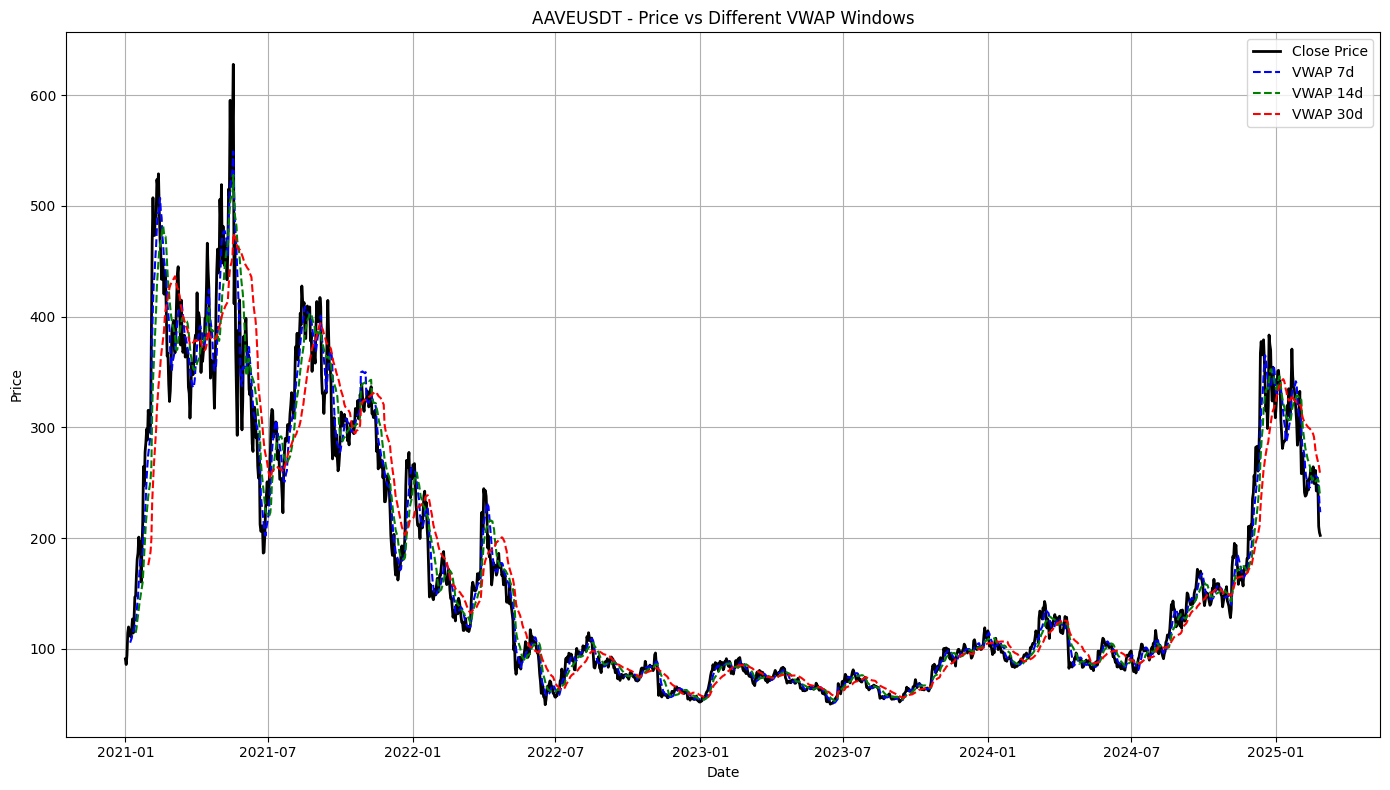

In [13]:
# 繪製不同窗口的 VWAP 與價格的比較圖
def plot_price_vs_vwaps(symbol_name):
    symbol_data = df[df['symbol'] == symbol_name].copy()
    
    plt.figure(figsize=(14, 8))
    plt.plot(symbol_data['open_time'], symbol_data['close'], label='Close Price', color='black', linewidth=2)
    
    colors = ['blue', 'green', 'red', 'purple']
    for i, window in enumerate(windows):
        col_name = f'vwap_{window}d'
        plt.plot(symbol_data['open_time'], symbol_data[col_name], 
                 label=f'VWAP {window}d', color=colors[i], linestyle='--')
    
    plt.title(f'{symbol_name} - Price vs Different VWAP Windows')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 可選：添加 VWAP 與收盤價差距的計算
for window in windows:
    col_name = f'vwap_{window}d'
    diff_col = f'vwap_{window}d_diff'
    df[diff_col] = ((df['close'] - df[col_name]) / df[col_name]) * 100  # 差距百分比

# 計算 VWAP 的趨勢方向 (上升或下降)
for window in windows:
    col_name = f'vwap_{window}d'
    trend_col = f'vwap_{window}d_trend'
    df[trend_col] = df.groupby('symbol')[col_name].pct_change()
    
    # 正值表示上升，負值表示下降
    df[f'{trend_col}_direction'] = np.where(df[trend_col] > 0, 'Up', 'Down')


# 例如，為 AAVEUSDT 繪製圖表
plot_price_vs_vwaps('AAVEUSDT')

In [14]:
df

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,vwap_30d,vwap_7d_diff,vwap_14d_diff,vwap_30d_diff,vwap_7d_trend,vwap_7d_trend_direction,vwap_14d_trend,vwap_14d_trend_direction,vwap_30d_trend,vwap_30d_trend_direction
0,AAVEUSDT,2021-01-01,88.581,91.000,84.652,90.909,368132.6,3.236081e+07,95220,160420.1,...,NaN,NaN,NaN,NaN,NaN,Down,NaN,Down,NaN,Down
1,AAVEUSDT,2021-01-02,90.940,92.200,82.573,85.888,350675.1,3.019238e+07,96482,141557.9,...,NaN,NaN,NaN,NaN,NaN,Down,NaN,Down,NaN,Down
2,AAVEUSDT,2021-01-03,85.911,95.680,81.338,94.185,490412.4,4.367915e+07,120659,219913.4,...,NaN,NaN,NaN,NaN,NaN,Down,NaN,Down,NaN,Down
3,AAVEUSDT,2021-01-04,94.183,115.590,85.932,114.322,1108493.1,1.136470e+08,301713,514642.8,...,NaN,NaN,NaN,NaN,NaN,Down,NaN,Down,NaN,Down
4,AAVEUSDT,2021-01-05,114.344,124.279,98.653,119.800,843809.1,9.551636e+07,271640,385402.1,...,NaN,NaN,NaN,NaN,NaN,Down,NaN,Down,NaN,Down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31873,XTZUSDT,2025-02-22,0.870,0.899,0.867,0.893,9587461.5,8.503384e+06,46368,4670777.7,...,0.928233,1.622738,0.910180,-3.795695,-0.001780,Down,0.002311,Up,-0.009389,Down
31874,XTZUSDT,2025-02-23,0.893,0.895,0.858,0.865,5712478.5,5.005713e+06,39536,2578248.6,...,0.921987,-1.234192,-2.246972,-6.180840,-0.003336,Down,-0.000070,Down,-0.006729,Down
31875,XTZUSDT,2025-02-24,0.865,0.866,0.761,0.773,19900237.0,1.618839e+07,91384,9703884.8,...,0.915149,-9.557121,-11.694078,-15.532912,-0.024122,Down,-0.010755,Down,-0.007416,Down
31876,XTZUSDT,2025-02-25,0.772,0.791,0.725,0.777,28215329.7,2.147710e+07,112628,14213387.9,...,0.904466,-5.980597,-9.426829,-14.092972,-0.033062,Down,-0.019987,Down,-0.011674,Down


RSI 

In [16]:
import pandas as pd
import numpy as np

# 計算 RSI 函數
def calculate_rsi(df, window=14, column='close'):
    # 確保按 symbol 和時間排序
    df = df.sort_values(['symbol', 'open_time'])
    
    # 創建結果 DataFrame
    result_df = df.copy()
    result_df[f'rsi_{window}'] = np.nan
    
    # 對每個 symbol 單獨計算 RSI
    for symbol, group in df.groupby('symbol'):
        # 計算價格變化
        price_diff = group[column].diff()
        
        # 提取上漲和下跌
        gain = price_diff.where(price_diff > 0, 0)
        loss = -price_diff.where(price_diff < 0, 0)
        
        # 計算平均上漲和下跌
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        
        # 計算相對強度 (RS)
        rs = avg_gain / avg_loss
        
        # 計算 RSI
        rsi = 100 - (100 / (1 + rs))
        
        # 更新原始 DataFrame
        result_df.loc[group.index, f'rsi_{window}'] = rsi
    
    return result_df

# 使用函數計算不同窗口的 RSI
windows = [7, 14, 21]  # 常用的 RSI 窗口

for window in windows:
    df = calculate_rsi(df, window=window)

# 顯示結果
print(df[['symbol', 'open_time', 'close', 'rsi_14', 'rsi_7', 'rsi_21']].head(22))

      symbol  open_time    close     rsi_14       rsi_7     rsi_21
0   AAVEUSDT 2021-01-01   90.909        NaN         NaN        NaN
1   AAVEUSDT 2021-01-02   85.888        NaN         NaN        NaN
2   AAVEUSDT 2021-01-03   94.185        NaN         NaN        NaN
3   AAVEUSDT 2021-01-04  114.322        NaN         NaN        NaN
4   AAVEUSDT 2021-01-05  119.800        NaN         NaN        NaN
5   AAVEUSDT 2021-01-06  115.719        NaN         NaN        NaN
6   AAVEUSDT 2021-01-07  115.235        NaN   77.962205        NaN
7   AAVEUSDT 2021-01-08  110.686        NaN   70.580890        NaN
8   AAVEUSDT 2021-01-09  117.674        NaN   81.777102        NaN
9   AAVEUSDT 2021-01-10  126.987        NaN   82.139918        NaN
10  AAVEUSDT 2021-01-11  114.329        NaN   50.008037        NaN
11  AAVEUSDT 2021-01-12  127.740        NaN   57.711134        NaN
12  AAVEUSDT 2021-01-13  146.778        NaN   73.373369        NaN
13  AAVEUSDT 2021-01-14  147.766  75.740427   74.296811       

In [18]:
df

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,vwap_30d_diff,vwap_7d_trend,vwap_7d_trend_direction,vwap_14d_trend,vwap_14d_trend_direction,vwap_30d_trend,vwap_30d_trend_direction,rsi_7,rsi_14,rsi_21
0,AAVEUSDT,2021-01-01,88.581,91.000,84.652,90.909,368132.6,3.236081e+07,95220,160420.1,...,NaN,NaN,Down,NaN,Down,NaN,Down,NaN,NaN,NaN
1,AAVEUSDT,2021-01-02,90.940,92.200,82.573,85.888,350675.1,3.019238e+07,96482,141557.9,...,NaN,NaN,Down,NaN,Down,NaN,Down,NaN,NaN,NaN
2,AAVEUSDT,2021-01-03,85.911,95.680,81.338,94.185,490412.4,4.367915e+07,120659,219913.4,...,NaN,NaN,Down,NaN,Down,NaN,Down,NaN,NaN,NaN
3,AAVEUSDT,2021-01-04,94.183,115.590,85.932,114.322,1108493.1,1.136470e+08,301713,514642.8,...,NaN,NaN,Down,NaN,Down,NaN,Down,NaN,NaN,NaN
4,AAVEUSDT,2021-01-05,114.344,124.279,98.653,119.800,843809.1,9.551636e+07,271640,385402.1,...,NaN,NaN,Down,NaN,Down,NaN,Down,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31873,XTZUSDT,2025-02-22,0.870,0.899,0.867,0.893,9587461.5,8.503384e+06,46368,4670777.7,...,-3.795695,-0.001780,Down,0.002311,Up,-0.009389,Down,52.482270,52.842809,41.025641
31874,XTZUSDT,2025-02-23,0.893,0.895,0.858,0.865,5712478.5,5.005713e+06,39536,2578248.6,...,-6.180840,-0.003336,Down,-0.000070,Down,-0.006729,Down,39.873418,47.839506,48.120301
31875,XTZUSDT,2025-02-24,0.865,0.866,0.761,0.773,19900237.0,1.618839e+07,91384,9703884.8,...,-15.532912,-0.024122,Down,-0.010755,Down,-0.007416,Down,25.925926,35.235732,35.551664
31876,XTZUSDT,2025-02-25,0.772,0.791,0.725,0.777,28215329.7,2.147710e+07,112628,14213387.9,...,-14.092972,-0.033062,Down,-0.019987,Down,-0.011674,Down,31.753555,38.522427,40.272374


EMA 


In [20]:
import pandas as pd
import numpy as np

# 修正後的 EMA 計算函數
def calculate_ema(df, windows=[7, 14, 30], column='close'):
    # 確保按 symbol 和時間排序
    df = df.sort_values(['symbol', 'open_time'])
    
    # 創建結果 DataFrame
    result_df = df.copy()
    
    # 對每個 symbol 單獨計算 EMA
    for symbol, group in df.groupby('symbol'):
        for window in windows:
            # 先計算 SMA 作為有效 EMA 的起點
            sma = group[column].rolling(window=window).mean()
            
            # 創建 EMA 結果序列，初始值設為 NaN
            ema_values = np.full(len(group), np.nan)
            
            # 從第一個有效的 SMA 位置開始計算 EMA
            first_valid = window - 1  # SMA 從第 window 個位置開始有效
            if first_valid < len(group) and not np.isnan(sma.iloc[first_valid]):
                ema_values[first_valid] = sma.iloc[first_valid]
                
                # 計算後續的 EMA
                alpha = 2 / (window + 1)
                for i in range(first_valid + 1, len(group)):
                    price = group[column].iloc[i]
                    prev_ema = ema_values[i - 1]
                    if not np.isnan(price) and not np.isnan(prev_ema):
                        ema_values[i] = price * alpha + prev_ema * (1 - alpha)
            
            # 更新結果 DataFrame
            result_df.loc[group.index, f'ema_{window}'] = ema_values
    
    return result_df

# 使用函數計算不同窗口的 EMA
ema_windows = [7, 14, 30]  # 不同窗口的 EMA
df = calculate_ema(df, windows=ema_windows)

# 顯示結果
columns_to_show = ['symbol', 'open_time', 'close'] + [f'ema_{w}' for w in ema_windows]
print(df[columns_to_show].head(30))

      symbol  open_time    close       ema_7      ema_14      ema_30
0   AAVEUSDT 2021-01-01   90.909         NaN         NaN         NaN
1   AAVEUSDT 2021-01-02   85.888         NaN         NaN         NaN
2   AAVEUSDT 2021-01-03   94.185         NaN         NaN         NaN
3   AAVEUSDT 2021-01-04  114.322         NaN         NaN         NaN
4   AAVEUSDT 2021-01-05  119.800         NaN         NaN         NaN
5   AAVEUSDT 2021-01-06  115.719         NaN         NaN         NaN
6   AAVEUSDT 2021-01-07  115.235  105.151143         NaN         NaN
7   AAVEUSDT 2021-01-08  110.686  106.534857         NaN         NaN
8   AAVEUSDT 2021-01-09  117.674  109.319643         NaN         NaN
9   AAVEUSDT 2021-01-10  126.987  113.736482         NaN         NaN
10  AAVEUSDT 2021-01-11  114.329  113.884612         NaN         NaN
11  AAVEUSDT 2021-01-12  127.740  117.348459         NaN         NaN
12  AAVEUSDT 2021-01-13  146.778  124.705844         NaN         NaN
13  AAVEUSDT 2021-01-14  147.766  

In [21]:
df

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,vwap_14d_trend_direction,vwap_30d_trend,vwap_30d_trend_direction,rsi_7,rsi_14,rsi_21,ema_7,ema_14,ema_30,ema_90
0,AAVEUSDT,2021-01-01,88.581,91.000,84.652,90.909,368132.6,3.236081e+07,95220,160420.1,...,Down,NaN,Down,NaN,NaN,NaN,NaN,NaN,NaN,90.909000
1,AAVEUSDT,2021-01-02,90.940,92.200,82.573,85.888,350675.1,3.019238e+07,96482,141557.9,...,Down,NaN,Down,NaN,NaN,NaN,NaN,NaN,NaN,90.798648
2,AAVEUSDT,2021-01-03,85.911,95.680,81.338,94.185,490412.4,4.367915e+07,120659,219913.4,...,Down,NaN,Down,NaN,NaN,NaN,NaN,NaN,NaN,90.873074
3,AAVEUSDT,2021-01-04,94.183,115.590,85.932,114.322,1108493.1,1.136470e+08,301713,514642.8,...,Down,NaN,Down,NaN,NaN,NaN,NaN,NaN,NaN,91.388435
4,AAVEUSDT,2021-01-05,114.344,124.279,98.653,119.800,843809.1,9.551636e+07,271640,385402.1,...,Down,NaN,Down,NaN,NaN,NaN,NaN,NaN,NaN,92.012865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31873,XTZUSDT,2025-02-22,0.870,0.899,0.867,0.893,9587461.5,8.503384e+06,46368,4670777.7,...,Up,-0.009389,Down,52.482270,52.842809,41.025641,0.883715,0.895498,0.961875,1.070583
31874,XTZUSDT,2025-02-23,0.893,0.895,0.858,0.865,5712478.5,5.005713e+06,39536,2578248.6,...,Down,-0.006729,Down,39.873418,47.839506,48.120301,0.879036,0.891432,0.955625,1.066065
31875,XTZUSDT,2025-02-24,0.865,0.866,0.761,0.773,19900237.0,1.618839e+07,91384,9703884.8,...,Down,-0.007416,Down,25.925926,35.235732,35.551664,0.852527,0.875641,0.943842,1.059624
31876,XTZUSDT,2025-02-25,0.772,0.791,0.725,0.777,28215329.7,2.147710e+07,112628,14213387.9,...,Down,-0.011674,Down,31.753555,38.522427,40.272374,0.833645,0.862489,0.933078,1.053412


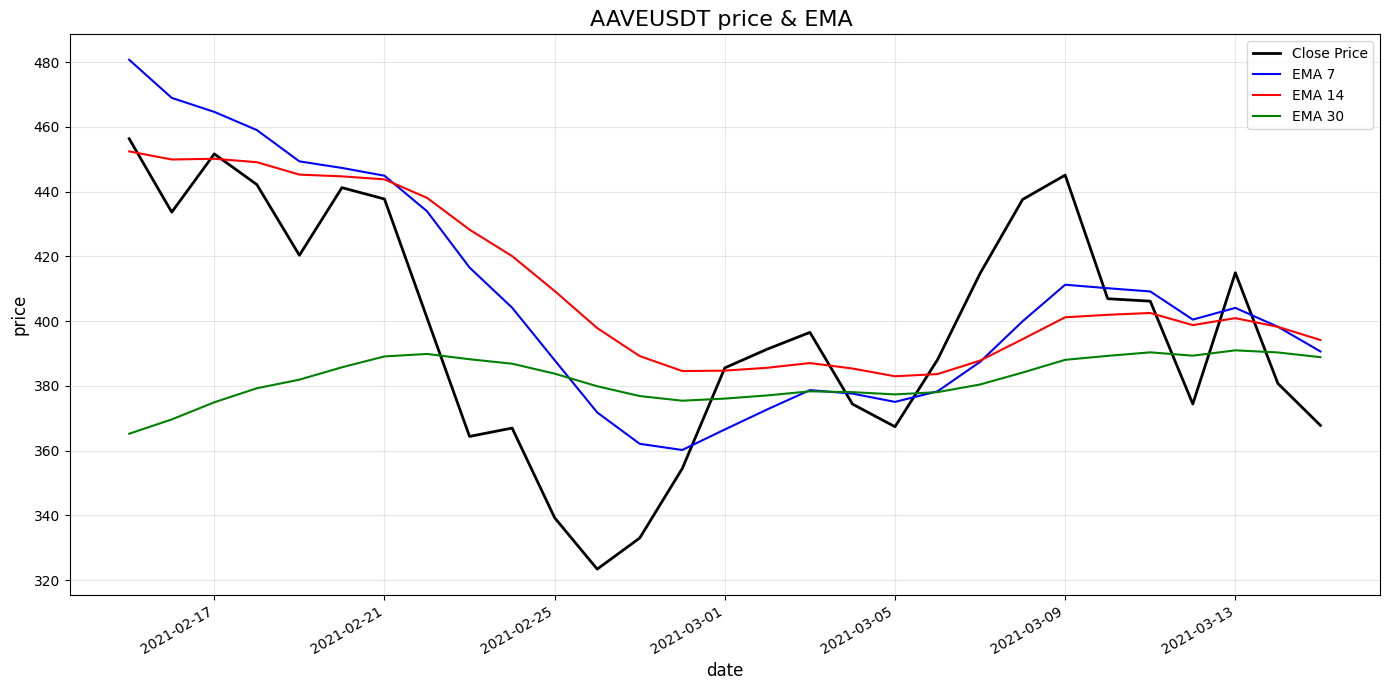

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_ema_with_price(df, symbol, windows=[7, 14, 30], start_date=None, end_date=None):
    """
    繪製特定加密貨幣的收盤價和多條 EMA 曲線
    
    參數:
    df : 包含價格和 EMA 數據的 DataFrame
    symbol : 要繪製的加密貨幣代碼
    windows : EMA 窗口大小列表
    start_date, end_date : 可選，限制圖表的日期範圍
    """
    # 篩選特定加密貨幣的數據
    symbol_data = df[df['symbol'] == symbol].copy()
    
    # 如果提供了日期範圍，則進行篩選
    if start_date:
        symbol_data = symbol_data[symbol_data['open_time'] >= pd.to_datetime(start_date)]
    if end_date:
        symbol_data = symbol_data[symbol_data['open_time'] <= pd.to_datetime(end_date)]
    
    # 創建圖表
    plt.figure(figsize=(14, 7))
    
    # 繪製收盤價
    plt.plot(symbol_data['open_time'], symbol_data['close'], label='Close Price', 
             color='black', linewidth=2)
    
    # 繪製不同窗口的 EMA 曲線
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']
    for i, window in enumerate(windows):
        col_name = f'ema_{window}'
        if col_name in symbol_data.columns:
            color_idx = i % len(colors)  # 循環使用顏色列表
            plt.plot(symbol_data['open_time'], symbol_data[col_name], 
                     label=f'EMA {window}', color=colors[color_idx], linewidth=1.5)
    
    # 設置圖表格式
    plt.title(f'{symbol} price & EMA ', fontsize=16)
    plt.xlabel('date', fontsize=12)
    plt.ylabel('price', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    
    # 格式化 x 軸日期
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()



# 繪製所有可用的 EMA 窗口
def plot_all_symbols_ema(df, windows=[7, 14, 30], max_symbols=5):
    """
    為 DataFrame 中的前 N 個 symbols 繪製 EMA 圖表
    """
    # 獲取唯一的加密貨幣列表
    unique_symbols = df['symbol'].unique()
    
    # 限制繪製的加密貨幣數量
    plot_symbols = unique_symbols[:min(max_symbols, len(unique_symbols))]
    
    # 為每個加密貨幣繪製 EMA 圖表
    for symbol in plot_symbols:
        print(f"\n正在繪製 {symbol} 的 EMA 圖表...")
        plot_ema_with_price(df, symbol, windows=windows)
        
        


# 繪製特定日期範圍內的數據
plot_ema_with_price(df, 'AAVEUSDT', windows=[7, 14, 30], 
                    start_date='2021-02-15', end_date='2021-03-15')

ATR 

In [23]:
import pandas as pd
import numpy as np

# 計算 ATR 函數
def calculate_atr(df, windows=[14], column='close'):
    # 確保按 symbol 和時間排序
    df = df.sort_values(['symbol', 'open_time'])
    
    # 創建結果 DataFrame
    result_df = df.copy()
    
    # 對每個 symbol 單獨計算 ATR
    for symbol, group in df.groupby('symbol'):
        # 計算 True Range
        group = group.copy()  # 避免 SettingWithCopyWarning
        
        # 計算三種價格差值
        high_low = group['high'] - group['low']
        high_close_prev = abs(group['high'] - group['close'].shift(1))
        low_close_prev = abs(group['low'] - group['close'].shift(1))
        
        # 取三者中的最大值作為 True Range
        tr = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)
        
        # 為每個窗口計算 ATR
        for window in windows:
            # 使用簡單移動平均計算 ATR
            atr_sma = tr.rolling(window=window).mean()
            
            # 也可以使用 Wilder 的平滑方法計算 ATR (更常用)
            atr_wilder = tr.copy()
            atr_wilder_series = pd.Series(index=group.index, dtype=float)
            
            # 填充 NaN 值
            atr_wilder_series.iloc[:window-1] = np.nan
            
            # 第一個值使用簡單平均
            if len(tr) >= window:
                atr_wilder_series.iloc[window-1] = tr.iloc[:window].mean()
                
                # 後續使用 Wilder 平滑法
                alpha = 1.0 / window
                for i in range(window, len(tr)):
                    prev_atr = atr_wilder_series.iloc[i-1]
                    if not np.isnan(prev_atr):
                        atr_wilder_series.iloc[i] = alpha * tr.iloc[i] + (1 - alpha) * prev_atr
            
            # 更新結果 DataFrame
            result_df.loc[group.index, f'atr_{window}'] = atr_wilder_series
    
    return result_df

# 使用函數計算不同窗口的 ATR
atr_windows = [7, 14, 21]  # 常用的 ATR 窗口
df = calculate_atr(df, windows=atr_windows)

# 顯示結果
columns_to_show = ['symbol', 'open_time', 'high', 'low', 'close'] + [f'atr_{w}' for w in atr_windows]
print(df[columns_to_show].head(21))

      symbol  open_time     high      low    close      atr_7     atr_14  \
0   AAVEUSDT 2021-01-01   91.000   84.652   90.909        NaN        NaN   
1   AAVEUSDT 2021-01-02   92.200   82.573   85.888        NaN        NaN   
2   AAVEUSDT 2021-01-03   95.680   81.338   94.185        NaN        NaN   
3   AAVEUSDT 2021-01-04  115.590   85.932  114.322        NaN        NaN   
4   AAVEUSDT 2021-01-05  124.279   98.653  119.800        NaN        NaN   
5   AAVEUSDT 2021-01-06  121.023  107.856  115.719        NaN        NaN   
6   AAVEUSDT 2021-01-07  131.000  107.000  115.235  17.538286        NaN   
7   AAVEUSDT 2021-01-08  120.040  100.240  110.686  17.861388        NaN   
8   AAVEUSDT 2021-01-09  119.548  106.062  117.674  17.236332        NaN   
9   AAVEUSDT 2021-01-10  137.000  111.072  126.987  18.477999        NaN   
10  AAVEUSDT 2021-01-11  127.609   94.000  114.329  20.639571        NaN   
11  AAVEUSDT 2021-01-12  136.146  109.109  127.740  21.553489        NaN   
12  AAVEUSDT

MACD

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def calculate_macd(df, fast_period=12, slow_period=26, signal_period=9, column='close'):
    """
    計算 MACD 指標
    
    參數:
    df : DataFrame 包含價格數據
    fast_period : 快線 EMA 週期，默認為 12
    slow_period : 慢線 EMA 週期，默認為 26
    signal_period : 信號線週期，默認為 9
    column : 用於計算的價格列，默認為 'close'
    
    返回:
    添加了 MACD 相關列的 DataFrame
    """
    # 確保按 symbol 和時間排序
    df = df.sort_values(['symbol', 'open_time'])
    
    # 創建結果 DataFrame
    result_df = df.copy()
    
    # 對每個 symbol 單獨計算 MACD
    for symbol, group in df.groupby('symbol'):
        # 計算快速和慢速 EMA
        fast_ema = group[column].ewm(span=fast_period, adjust=False).mean()
        slow_ema = group[column].ewm(span=slow_period, adjust=False).mean()
        
        # 計算 MACD 線和信號線
        macd_line = fast_ema - slow_ema
        signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
        
        # 計算 MACD 柱狀圖 (Histogram)
        histogram = macd_line - signal_line
        
        # 更新結果 DataFrame
        result_df.loc[group.index, 'macd_line'] = macd_line
        result_df.loc[group.index, 'macd_signal'] = signal_line
        result_df.loc[group.index, 'macd_histogram'] = histogram
    
    return result_df



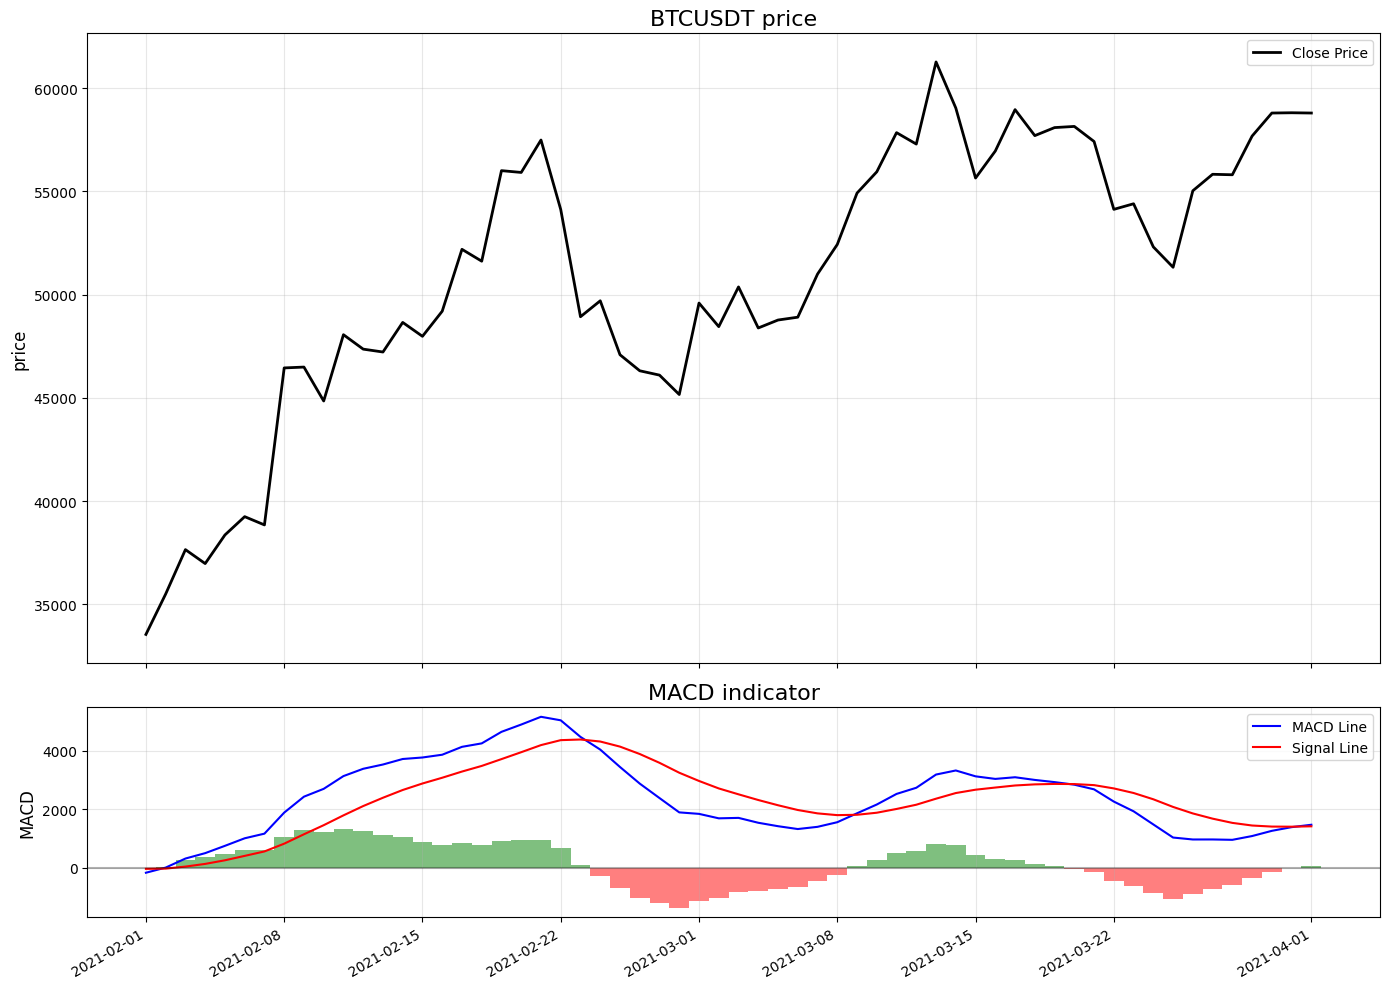

In [32]:
def plot_macd(df, symbol, start_date=None, end_date=None):
    """
    繪製特定加密貨幣的價格和 MACD 指標
    
    參數:
    df : DataFrame 包含價格和 MACD 數據
    symbol : 要繪製的加密貨幣代碼
    start_date, end_date : 可選，限制圖表的日期範圍
    """
    # 篩選特定加密貨幣的數據
    symbol_data = df[df['symbol'] == symbol].copy()
    
    # 如果提供了日期範圍，則進行篩選
    if start_date:
        symbol_data = symbol_data[symbol_data['open_time'] >= pd.to_datetime(start_date)]
    if end_date:
        symbol_data = symbol_data[symbol_data['open_time'] <= pd.to_datetime(end_date)]
    
    # 創建子圖
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # 上圖：繪製收盤價
    ax1.plot(symbol_data['open_time'], symbol_data['close'], label='Close Price', color='black', linewidth=2)
    ax1.set_title(f'{symbol} price', fontsize=16)
    ax1.set_ylabel('price', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best')
    
    # 下圖：繪製 MACD
    # MACD 線和信號線
    ax2.plot(symbol_data['open_time'], symbol_data['macd_line'], label='MACD Line', color='blue', linewidth=1.5)
    ax2.plot(symbol_data['open_time'], symbol_data['macd_signal'], label='Signal Line', color='red', linewidth=1.5)
    
    # MACD 柱狀圖
    for i in range(len(symbol_data)):
        if i > 0:  # 確保有前一個數據點
            hist_val = symbol_data['macd_histogram'].iloc[i]
            color = 'green' if hist_val >= 0 else 'red'
            ax2.bar(symbol_data['open_time'].iloc[i], hist_val, width=1, color=color, alpha=0.5)
    
    # 添加零線
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    ax2.set_title('MACD indicator', fontsize=16)
    ax2.set_ylabel('MACD', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best')
    
    # 格式化 x 軸日期
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

# 使用方法示例
# 首先計算 MACD
df = calculate_macd(df)

# 然後繪製 MACD 圖表
# plot_macd(df, 'AAVEUSDT')

# 帶日期範圍的 MACD 繪圖
plot_macd(df, 'BTCUSDT', start_date='2021-02-01', end_date='2021-04-01')

Quintile Factors 

alpha 1 : 
-ts_corr(ts_rank(close, 10), ts_rank(volume, 10), 16)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def ts_rank(series, window):
    """
    對滾動窗口內的時間序列進行排名，只使用過去數據
    """
    result = pd.Series(index=series.index, dtype=float)
    
    for i in range(window, len(series)):
        if not series.iloc[i-window:i].isna().any():
            window_data = series.iloc[i-window:i]
            result.iloc[i] = window_data.rank().iloc[-1]
    
    return result

def calculate_alpha(df, close_window=5, volume_window=5, corr_window=10):
    """
    計算 alpha 指標: -ts_corr(ts_rank(close, close_window), ts_rank(volume, volume_window), corr_window)
    避免前瞻性偏差
    
    參數:
    df : DataFrame 包含價格和成交量數據
    close_window : 收盤價排名窗口大小
    volume_window : 成交量排名窗口大小
    corr_window : 相關性計算窗口大小
    
    返回:
    添加了 alpha 指標的 DataFrame
    """
    # 確保按 symbol 和時間排序
    df = df.sort_values(['symbol', 'open_time'])
    
    # 創建結果 DataFrame
    result_df = df.copy()
    result_df['alpha1'] = np.nan
    
    # 對每個 symbol 單獨計算 alpha
    for symbol, group in df.groupby('symbol'):
        # 使用滯後數據
        close_lag = group['close'].shift(1)
        volume_lag = group['volume'].shift(1)
        
        # 計算時間序列排名
        close_rank = pd.Series(index=group.index, dtype=float)
        volume_rank = pd.Series(index=group.index, dtype=float)
        
        # 計算滾動排名
        for i in range(close_window, len(group)):
            if not close_lag.iloc[i-close_window:i].isna().any():
                window_data = close_lag.iloc[i-close_window:i]
                close_rank.iloc[i] = window_data.rank().iloc[-1]
                
        for i in range(volume_window, len(group)):
            if not volume_lag.iloc[i-volume_window:i].isna().any():
                window_data = volume_lag.iloc[i-volume_window:i]
                volume_rank.iloc[i] = window_data.rank().iloc[-1]
        
        # 計算滾動相關性
        alpha = pd.Series(index=group.index, dtype=float)
        
        for i in range(corr_window + max(close_window, volume_window), len(group)):
            close_window_data = close_rank.iloc[i-corr_window:i]
            volume_window_data = volume_rank.iloc[i-corr_window:i]
            
            if not (close_window_data.isna().any() or volume_window_data.isna().any()):
                # 使用 Spearman 相關係數
                alpha.iloc[i] = -stats.spearmanr(close_window_data, volume_window_data)[0]
        
        # 更新結果 DataFrame
        result_df.loc[group.index, 'alpha1'] = alpha
    
    return result_df



In [42]:
def plot_alpha_with_price(df, symbol, start_date=None, end_date=None):
    """
    繪製特定加密貨幣的價格和 Alpha 指標
    
    參數:
    df : DataFrame 包含價格和 Alpha 數據
    symbol : 要繪製的加密貨幣代碼
    start_date, end_date : 可選，限制圖表的日期範圍
    """
    # 篩選特定加密貨幣的數據
    symbol_data = df[df['symbol'] == symbol].copy()
    
    # 如果提供了日期範圍，則進行篩選
    if start_date:
        symbol_data = symbol_data[symbol_data['open_time'] >= pd.to_datetime(start_date)]
    if end_date:
        symbol_data = symbol_data[symbol_data['open_time'] <= pd.to_datetime(end_date)]
    
    # 創建子圖
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    
    # 上圖：繪製收盤價
    ax1.plot(symbol_data['open_time'], symbol_data['close'], label='Close Price', color='black', linewidth=2)
    ax1.set_title(f'{symbol} price', fontsize=16)
    ax1.set_ylabel('price', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best')
    
    # 下圖：繪製 Alpha 指標
    ax2.plot(symbol_data['open_time'], symbol_data['alpha1'], label='Alpha', color='blue', linewidth=1.5)
    
    # 添加零線
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 添加參考線
    ax2.axhline(y=0.5, color='green', linestyle='--', alpha=0.3)
    ax2.axhline(y=-0.5, color='red', linestyle='--', alpha=0.3)
    
    ax2.set_title('Alpha indicator', fontsize=16)
    ax2.set_ylabel('Alpha1', fontsize=12)
    ax2.set_ylim(-1.1, 1.1)  # 相關係數的範圍是 -1 到 1
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='best')
    
    # 格式化 x 軸日期
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()



In [ ]:
# calculate alpha 

df = calculate_alpha(df, close_window=10, volume_window=10, corr_window=16)

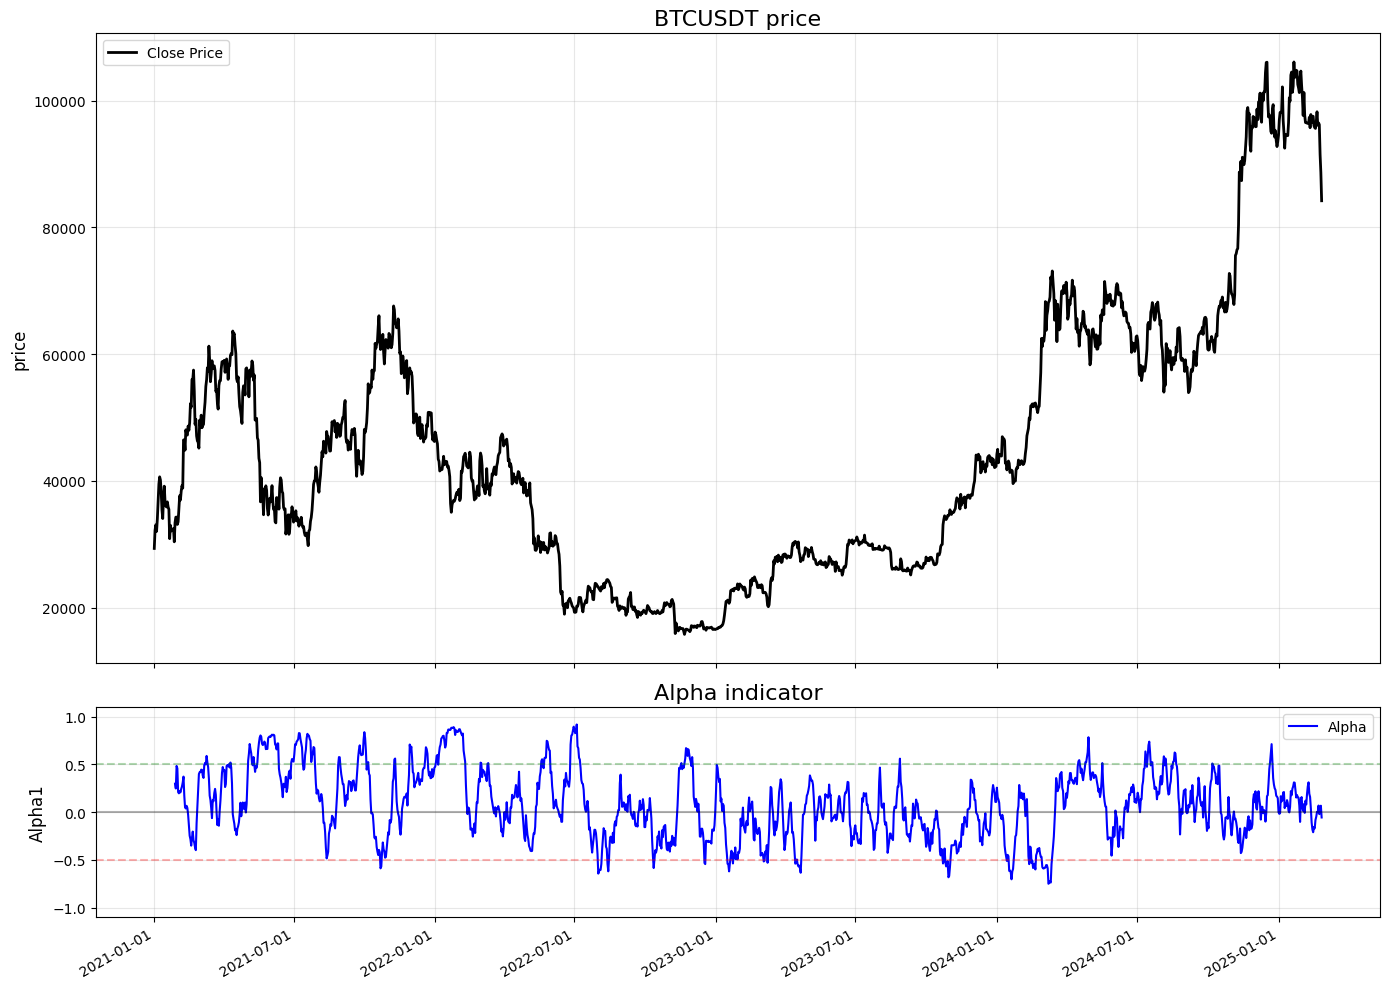

In [43]:
# 繪製 Alpha 圖表
plot_alpha_with_price(df, 'BTCUSDT')

In [41]:
df

,symbol,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,...,ema_14,ema_30,ema_90,atr_7,atr_14,atr_21,macd_line,macd_signal,macd_histogram,alpha1
0,AAVEUSDT,2021-01-01,88.581,91.000,84.652,90.909,368132.6,3.236081e+07,95220,160420.1,...,NaN,NaN,90.909000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
1,AAVEUSDT,2021-01-02,90.940,92.200,82.573,85.888,350675.1,3.019238e+07,96482,141557.9,...,NaN,NaN,90.798648,NaN,NaN,NaN,-0.400536,-0.080107,-0.320428,NaN
2,AAVEUSDT,2021-01-03,85.911,95.680,81.338,94.185,490412.4,4.367915e+07,120659,219913.4,...,NaN,NaN,90.873074,NaN,NaN,NaN,-0.047912,-0.073668,0.025756,NaN
3,AAVEUSDT,2021-01-04,94.183,115.590,85.932,114.322,1108493.1,1.136470e+08,301713,514642.8,...,NaN,NaN,91.388435,NaN,NaN,NaN,1.835276,0.308121,1.527155,NaN
4,AAVEUSDT,2021-01-05,114.344,124.279,98.653,119.800,843809.1,9.551636e+07,271640,385402.1,...,NaN,NaN,92.012865,NaN,NaN,NaN,3.726785,0.991854,2.734932,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31873,XTZUSDT,2025-02-22,0.870,0.899,0.867,0.893,9587461.5,8.503384e+06,46368,4670777.7,...,0.895498,0.961875,1.070583,0.054723,0.067753,0.077551,-0.053680,-0.067857,0.014177,0.622363
31874,XTZUSDT,2025-02-23,0.893,0.895,0.858,0.865,5712478.5,5.005713e+06,39536,2578248.6,...,0.891432,0.955625,1.066065,0.052191,0.065557,0.075620,-0.051723,-0.064630,0.012907,0.512835
31875,XTZUSDT,2025-02-24,0.865,0.866,0.761,0.773,19900237.0,1.618839e+07,91384,9703884.8,...,0.875641,0.943842,1.059624,0.059735,0.068374,0.077019,-0.056939,-0.063092,0.006153,0.515081
31876,XTZUSDT,2025-02-25,0.772,0.791,0.725,0.777,28215329.7,2.147710e+07,112628,14213387.9,...,0.862489,0.933078,1.053412,0.060630,0.068205,0.076494,-0.060058,-0.062485,0.002427,0.396073


save to parquet 

In [44]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

def save_to_parquet(df, file_path, compression='snappy'):
    """
    將 DataFrame 儲存為 Parquet 檔案
    
    參數:
    df : DataFrame 要儲存的資料
    file_path : 字串，檔案儲存路徑 (例如 'crypto_indicators.parquet')
   
    """
    try:
        # 儲存成 Parquet 檔案
        df.to_parquet(file_path, compression=compression)
        print(f"資料已成功儲存至 {file_path}")
        
        # 顯示檔案大小資訊
        import os
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # 轉換為 MB
        print(f"檔案大小: {file_size:.2f} MB")
        
    except Exception as e:
        print(f"儲存檔案時發生錯誤: {e}")

# 使用範例:
# 假設 df 已經包含了所有計算好的指標
save_to_parquet(df, 'agg_data.parquet')


資料已成功儲存至 agg_data.parquet
檔案大小: 11.09 MB
